# SINGAPORE PUBLIC HOUSING RESALE MARKET ANALYSIS

## 1. Data Cleaning and Mining

In [34]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from dython.nominal import correlation_ratio, cramers_v

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTENC

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV

In [2]:
df_raw = pd.read_csv('resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')

#change the 'month' column name to 'year_month'
df_raw = df_raw.rename(columns={'month':'year_month'})

# change data type in year_month column to date time
df_raw['year_month'] = pd.to_datetime(df_raw['year_month'], format='%Y-%m')

# extract year and month into separate columns from year_month
df_raw['month'] = df_raw['year_month'].dt.month
df_raw['year'] = df_raw['year_month'].dt.year

# rearrange the column's order
col = list(np.array(df_raw.columns)[[0, 11, 12]]) + list(np.array(df_raw.columns)[1:11])
df = df_raw[col]

df.head()

,year_month,month,year,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01-01,1,2017,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01-01,1,2017,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01-01,1,2017,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01-01,1,2017,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01-01,1,2017,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [3]:
#check the null and column's type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118166 entries, 0 to 118165
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   year_month           118166 non-null  datetime64[ns]
 1   month                118166 non-null  int64         
 2   year                 118166 non-null  int64         
 3   town                 118166 non-null  object        
 4   flat_type            118166 non-null  object        
 5   block                118166 non-null  object        
 6   street_name          118166 non-null  object        
 7   storey_range         118166 non-null  object        
 8   floor_area_sqm       118166 non-null  float64       
 9   flat_model           118166 non-null  object        
 10  lease_commence_date  118166 non-null  int64         
 11  remaining_lease      118166 non-null  object        
 12  resale_price         118166 non-null  float64       
dtypes: datetime64[

In [4]:
# extract each year and month from remaining lease and convert it into year (numeric)
year_rl = df['remaining_lease'].str.split(" ", expand=True)[0].fillna(0).astype(int)
month_rl = df['remaining_lease'].str.split(" ", expand=True)[2].fillna(0).astype(int)
df['year_remaining_lease'] = year_rl + (month_rl/12).round(decimals=2)

# extract median from storey_range
min_sr = df['storey_range'].str.split(" ", expand=True)[0].astype(int)
max_sr = df['storey_range'].str.split(" ", expand=True)[2].astype(int)
df['med_storey_range'] = (min_sr + max_sr)/2

# drop the unuse columns 
df = df.drop(columns=['remaining_lease'])

df.head()

,year_month,month,year,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year_remaining_lease,med_storey_range
0,2017-01-01,1,2017,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,232000.0,61.33,11.0
1,2017-01-01,1,2017,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,250000.0,60.58,2.0
2,2017-01-01,1,2017,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,262000.0,62.42,2.0
3,2017-01-01,1,2017,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,265000.0,62.08,5.0
4,2017-01-01,1,2017,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,265000.0,62.42,2.0


### - Per Town prespective

In [5]:
# extract number of street name and block per town
town_1 = pd.DataFrame(df.groupby("town")[[ 
                "block", 
                "street_name"]].nunique()).reset_index().rename(columns={
                                    "block" : "n_block_per_town",    
                                    "street_name" : "n_street_name_per_town"
                                })
town_1.head()

,town,n_block_per_town,n_street_name_per_town
0,ANG MO KIO,348,15
1,BEDOK,402,25
2,BISHAN,227,10
3,BUKIT BATOK,347,21
4,BUKIT MERAH,209,43


### - Per block prespective

In [6]:
# extract number of street name and block per town
block_1 = pd.DataFrame(df.groupby("block")[[ 
                "street_name"]].nunique()).reset_index().rename(columns={  
                                    "street_name" : "n_street_name_per_block"
                                })
block_1.head()

,block,n_street_name_per_block
0,1,23
1,10,18
2,100,4
3,101,27
4,101A,2


### - Merge Table

In [7]:
df_merge = pd.merge(df, town_1, on="town", how="outer")
df_merge = pd.merge(df_merge, block_1, on="block", how="outer")
df_merge.head()

,year_month,month,year,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year_remaining_lease,med_storey_range,n_block_per_town,n_street_name_per_town,n_street_name_per_block
0,2017-01-01,1,2017,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,232000.0,61.33,11.0,348,15,14
1,2017-05-01,5,2017,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,235000.0,61.08,11.0,348,15,14
2,2018-03-01,3,2018,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,202000.0,60.17,2.0,348,15,14
3,2018-03-01,3,2018,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,210000.0,60.17,2.0,348,15,14
4,2018-05-01,5,2018,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,07 TO 09,44.0,Improved,1979,220000.0,60.08,8.0,348,15,14


# C. Classification Problem

## 1. 

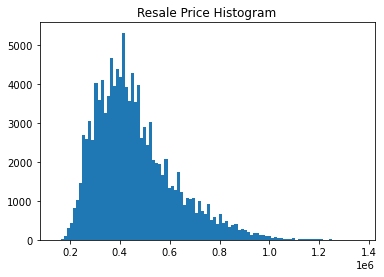

In [8]:
plt.hist(df_merge["resale_price"], bins=100)
plt.title("Resale Price Histogram")
plt.show()

we can get the idea about the boundary to classify what price is very affordable, affordable and not affordable. very affordable is when the price have more frequency than then others. based on that histogaram we can classify :

- Very Affordable : < 400,000 SGD
- Affordable : 400,000 - 600,000 SGD
- Not Affordable : > 600,000 SGD

In [9]:
df_merge["price_cat"] = ""
df_merge["price_cat"][df_merge["resale_price"] < 400000] = "very affordable"
df_merge["price_cat"][(df_merge["resale_price"] >= 400000) & (df_merge["resale_price"] <= 600000)] = "affordable"
df_merge["price_cat"][df_merge["resale_price"] > 600000] = "not affordable"
df_merge.head()

,year_month,month,year,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year_remaining_lease,med_storey_range,n_block_per_town,n_street_name_per_town,n_street_name_per_block,price_cat
0,2017-01-01,1,2017,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,232000.0,61.33,11.0,348,15,14,very affordable
1,2017-05-01,5,2017,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,235000.0,61.08,11.0,348,15,14,very affordable
2,2018-03-01,3,2018,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,202000.0,60.17,2.0,348,15,14,very affordable
3,2018-03-01,3,2018,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,210000.0,60.17,2.0,348,15,14,very affordable
4,2018-05-01,5,2018,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,07 TO 09,44.0,Improved,1979,220000.0,60.08,8.0,348,15,14,very affordable


## 2.

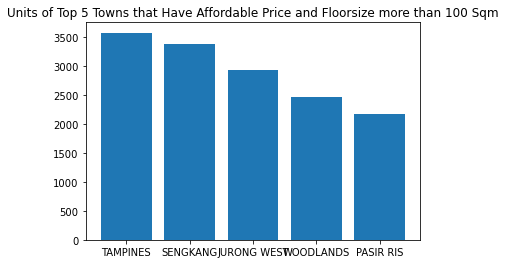

the town that give more proprtion for affordable flats and have floorsize more than 100 sqm is TAMPINES


In [10]:
case_1 = df_merge[(df_merge["floor_area_sqm"] > 100) & (df_merge["price_cat"]=="affordable")]
case_1_group = case_1.groupby("town").count().reset_index()
case_1_group = case_1_group.sort_values(by=case_1_group.columns[1], ascending=False)
plt.title("Units of Top 5 Towns that Have Affordable Price and Floorsize more than 100 Sqm")
plt.bar(case_1_group.iloc[:5]["town"], case_1_group.iloc[:5][case_1_group.columns[1]])
plt.show()

print("the town that give more proprtion for affordable flats and have floorsize more than 100 sqm is " + case_1_group.iloc[0]["town"])

## 3.

__Association__

finding the association between the price affordibility and other categoric fields

In [11]:
cat = [i for i in df_merge.columns if i not in df_merge.corr().columns and i != "year_month"]

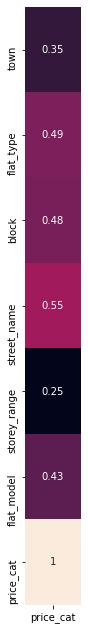

In [12]:
assoc_cramers = []
for i in cat:
    assoc = round(cramers_v(df_merge['price_cat'], df_merge[i]), 2)
    assoc_cramers.append(assoc)

data_cramers = pd.DataFrame(data = [assoc_cramers], columns = cat, index = ['price_cat'])

plt.figure(figsize=(1, 11))
sns.heatmap(data_cramers.T, annot=True, cbar=False)
plt.show()

__Correlation ratio__

finding the correlation between the resale price and other categoric fields

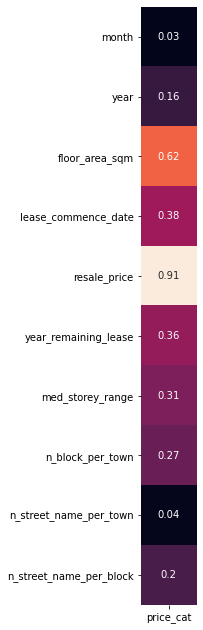

In [13]:
corr_rat = []
for i in df_merge.corr().columns:
    a = round(correlation_ratio(df_merge['price_cat'], df_merge[i]), 2)
    corr_rat.append(a)

data_corr_rat = pd.DataFrame(data = [corr_rat], columns = df_merge.corr().columns, index=["price_cat"])
plt.figure(figsize=(1, 11))
sns.heatmap(data_corr_rat.T, annot=True, cbar=False)
plt.show()

## 4.

### Building a Model

__DROP UNUSE FIELDS__

In [14]:
# drop resale_price, year_month and storey_range and block columns
# dropping block column because too much unique values

df_model = df_merge.drop(columns=["resale_price", "storey_range", "year_month", "block"])
df_model.head()

,month,year,town,flat_type,street_name,floor_area_sqm,flat_model,lease_commence_date,year_remaining_lease,med_storey_range,n_block_per_town,n_street_name_per_town,n_street_name_per_block,price_cat
0,1,2017,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,44.0,Improved,1979,61.33,11.0,348,15,14,very affordable
1,5,2017,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,44.0,Improved,1979,61.08,11.0,348,15,14,very affordable
2,3,2018,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,44.0,Improved,1979,60.17,2.0,348,15,14,very affordable
3,3,2018,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,44.0,Improved,1979,60.17,2.0,348,15,14,very affordable
4,5,2018,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,44.0,Improved,1979,60.08,8.0,348,15,14,very affordable


__DATA IMBALANCE CHECK__

In [15]:
# change target column values to numeric value

df_model['price_cat'][df_model['price_cat'] == 'very affordable'] = 0
df_model['price_cat'][df_model['price_cat'] == 'affordable'] = 1
df_model['price_cat'][df_model['price_cat'] == 'not affordable'] = 2
df_model['price_cat'] = df_model['price_cat'].astype('int64')
df_model.head()

,month,year,town,flat_type,street_name,floor_area_sqm,flat_model,lease_commence_date,year_remaining_lease,med_storey_range,n_block_per_town,n_street_name_per_town,n_street_name_per_block,price_cat
0,1,2017,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,44.0,Improved,1979,61.33,11.0,348,15,14,0
1,5,2017,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,44.0,Improved,1979,61.08,11.0,348,15,14,0
2,3,2018,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,44.0,Improved,1979,60.17,2.0,348,15,14,0
3,3,2018,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,44.0,Improved,1979,60.17,2.0,348,15,14,0
4,5,2018,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,44.0,Improved,1979,60.08,8.0,348,15,14,0


In [16]:
# Checking the value in street_name field that have only 1 freq

check_1 = df_model.groupby("street_name").count().reset_index()
list_check_1 = list(check_1[check_1[check_1.columns[1]]==1]["street_name"])

In [17]:
df_model = df_model[~df_model.street_name.isin(list_check_1)]
df_model.head()

,month,year,town,flat_type,street_name,floor_area_sqm,flat_model,lease_commence_date,year_remaining_lease,med_storey_range,n_block_per_town,n_street_name_per_town,n_street_name_per_block,price_cat
0,1,2017,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,44.0,Improved,1979,61.33,11.0,348,15,14,0
1,5,2017,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,44.0,Improved,1979,61.08,11.0,348,15,14,0
2,3,2018,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,44.0,Improved,1979,60.17,2.0,348,15,14,0
3,3,2018,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,44.0,Improved,1979,60.17,2.0,348,15,14,0
4,5,2018,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,44.0,Improved,1979,60.08,8.0,348,15,14,0


In [18]:
round(df_model['price_cat'].value_counts()/len(df_model)*100, 2)

1    42.54
0    40.14
2    17.32
Name: price_cat, dtype: float64

__SPLITTING DATA__

In [19]:
# seperate the columns into X and Y

X = df_model.drop(columns='price_cat')
y = df_model['price_cat']

In [20]:
# data splitting

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.20, random_state=42)

__OVER SAMPLING__

using SMOTE method __only for data training__

In [21]:
# make data frame from train data

df_train = pd.concat([X_train,y_train], axis=1)

In [22]:
# show df_train

df_train.head()

,month,year,town,flat_type,street_name,floor_area_sqm,flat_model,lease_commence_date,year_remaining_lease,med_storey_range,n_block_per_town,n_street_name_per_town,n_street_name_per_block,price_cat
117173,10,2018,YISHUN,5 ROOM,YISHUN AVE 11,112.0,Improved,2015,95.42,5.0,598,23,1,1
8956,7,2020,YISHUN,3 ROOM,YISHUN ST 21,67.0,New Generation,1985,64.25,11.0,598,23,12,0
108387,4,2019,SENGKANG,5 ROOM,RIVERVALE DR,110.0,Improved,2000,80.25,17.0,592,29,1,0
97382,3,2020,PUNGGOL,4 ROOM,EDGEFIELD PLAINS,92.0,Model A,2012,91.75,11.0,411,14,1,1
66306,3,2019,BUKIT PANJANG,4 ROOM,BT PANJANG RING RD,106.0,Model A,1988,68.67,14.0,331,14,12,0


In [23]:
# check data imbalance in df_train

round(df_train['price_cat'].value_counts()/len(df_train)*100, 2)

1    42.54
0    40.14
2    17.32
Name: price_cat, dtype: float64

In [24]:
# define the numeric columns and categoric columns from the dataset
all_columns = [i for i in df_train.columns]
num_columns = [i for i in df_train.corr().columns if i != "price_cat"]
cat_columns = [i for i in df_train.columns if i not in num_columns and i != "price_cat"]
idx_cat_columns = [all_columns.index(i) for i in cat_columns]

In [25]:
#SMOTE OVER SAMPLING
sm_cat = SMOTENC(random_state=42, categorical_features=idx_cat_columns)
X_sm, y_sm = sm_cat.fit_resample(X_train, y_train)

In [26]:
# Check Balance of target field
y_sm.value_counts()

2    40217
1    40217
0    40217
Name: price_cat, dtype: int64

__PIPELINE__

we used pipeline method for modelling
in a pipeline there are :
1. Robust scaler for Numeric Columns
2. One hot encoding for categoric columns

In [43]:
# create pipeline and model

numeric_pipeline = Pipeline([
    ('scaler', RobustScaler()),
#     ('poly', PolynomialFeatures(degree=2, include_bias=False)),
#     ('power', PowerTransformer(method='yeo-johnson'))
])

categoric_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns),
    ('categorical', categoric_pipeline, cat_columns)
])

pipe_LR = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression())
])

pipe_SVM = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=100))
])

pipe_DT = Pipeline([
    ('prep', preprocessor),
    ('algo', DecisionTreeClassifier(random_state=42))
])

__DEF FUNCTION FOR EVALUATION MATRIX__

Create a function that return the evaluation matrix (precission, recall, accuracy and confusion metrix

In [44]:
# def function for each model evaluation matrix

def conf_mat (Model, X_train, X_test, y_train, y_test,Nama):
    y_pred_test = Model.predict(X_test)
    cm_test = confusion_matrix(y_test, y_pred_test, labels=[2,1,0])
    df_test = pd.DataFrame(cm_test, index = ['Akt2', 'Akt1', 'Akt0'], columns=['Pred2', 'Pred1', 'Pred0'])
    print( 'Classification report data TEST ' + Nama + '\n\n', classification_report(y_test, y_pred_test))
    print('\nConfusion matrix data test ' + Nama + '\n\n')
    print(df_test)
    print('='*100)
    y_pred_train = Model.predict(X_train)
    cm_train = confusion_matrix(y_train, y_pred_train, labels=[2,1,0])
    df_train = pd.DataFrame(cm_train, index = ['Akt2', 'Akt1', 'Akt0'], columns=['Pred2', 'Pred1', 'Pred0'])
    print( 'Classification report data TRAIN ' + Nama + '\n\n', classification_report(y_train, y_pred_train))
    print('\nConfusion matrix data train ' + Nama + '\n\n')
    print(df_train)

In [55]:
# def function to compare the evaluation matrix for some models

def prec_rec (Model, X_test, y_test, Nama):
    data = {}
    prec = []
    rec = []
    acc = []
    for i in Model :
        y_pred_ts = i.predict(X_test)
        precision = precision_score(y_test, y_pred_ts, average="macro")
        recall = recall_score(y_test, y_pred_ts, average="macro")
        accuracy = accuracy_score(y_test, y_pred_ts)
        prec.append(precision)
        rec.append(recall)
        acc.append(accuracy)
    for j in range (len(Nama)):
        data[Nama[j]] = [prec[j], rec[j], acc[j]]
    
    df = pd.DataFrame(data, index=['Precison', 'Recall', 'Accuracy'])
    return df

__MODEL FITTING__

###########################

_LOGISTIC REGRESSION_

###########################

In [46]:
pipe_LR.fit(X_sm, y_sm)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['month', 'year',
                                                   'floor_area_sqm',
                                                   'lease_commence_date',
                                                   'year_remaining_lease',
                                                   'med_storey_range',
                                                   'n_block_per_town',
                                                   'n_street_name_per_town',
                                                   'n_street_name_per_block']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                       

In [47]:
# evaluation matrix of Logistic regression base model

conf_mat(pipe_LR, X_sm, X_test, y_sm, y_test, 'LR Base')

Classification report data TEST LR Base

               precision    recall  f1-score   support

           0       0.91      0.90      0.91      9487
           1       0.88      0.85      0.86     10054
           2       0.84      0.93      0.89      4092

    accuracy                           0.88     23633
   macro avg       0.88      0.89      0.89     23633
weighted avg       0.89      0.88      0.88     23633


Confusion matrix data test LR Base


      Pred2  Pred1  Pred0
Akt2   3822    267      3
Akt1    715   8500    839
Akt0      0    903   8584
Classification report data TRAIN LR Base

               precision    recall  f1-score   support

           0       0.92      0.90      0.91     40217
           1       0.85      0.85      0.85     40217
           2       0.93      0.95      0.94     40217

    accuracy                           0.90    120651
   macro avg       0.90      0.90      0.90    120651
weighted avg       0.90      0.90      0.90    120651


Confusion 

###########################

_Support Vector Machine (SVM)_

###########################

In [48]:
pipe_SVM.fit(X_sm, y_sm)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['month', 'year',
                                                   'floor_area_sqm',
                                                   'lease_commence_date',
                                                   'year_remaining_lease',
                                                   'med_storey_range',
                                                   'n_block_per_town',
                                                   'n_street_name_per_town',
                                                   'n_street_name_per_block']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                       

In [49]:
# evaluation matrix of SVM base model

conf_mat(pipe_SVM, X_sm, X_test, y_sm, y_test, 'SVM Base')

Classification report data TEST SVM Base

               precision    recall  f1-score   support

           0       0.55      0.91      0.69      9487
           1       0.61      0.19      0.29     10054
           2       0.62      0.73      0.67      4092

    accuracy                           0.57     23633
   macro avg       0.60      0.61      0.55     23633
weighted avg       0.59      0.57      0.52     23633


Confusion matrix data test SVM Base


      Pred2  Pred1  Pred0
Akt2   2967    415    710
Akt1   1820   1947   6287
Akt0      2    818   8667
Classification report data TRAIN SVM Base

               precision    recall  f1-score   support

           0       0.53      0.92      0.67     40217
           1       0.51      0.20      0.29     40217
           2       0.79      0.70      0.74     40217

    accuracy                           0.60    120651
   macro avg       0.61      0.60      0.57    120651
weighted avg       0.61      0.60      0.57    120651


Confusi

###########################

_DECISION TREE_

###########################

In [50]:
pipe_DT.fit(X_sm, y_sm)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['month', 'year',
                                                   'floor_area_sqm',
                                                   'lease_commence_date',
                                                   'year_remaining_lease',
                                                   'med_storey_range',
                                                   'n_block_per_town',
                                                   'n_street_name_per_town',
                                                   'n_street_name_per_block']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                       

In [51]:
# evaluation matrix of Decision Tree base model

conf_mat(pipe_DT, X_sm, X_test, y_sm, y_test, 'DT Base')

Classification report data TEST DT Base

               precision    recall  f1-score   support

           0       0.91      0.92      0.92      9487
           1       0.88      0.88      0.88     10054
           2       0.90      0.90      0.90      4092

    accuracy                           0.90     23633
   macro avg       0.90      0.90      0.90     23633
weighted avg       0.90      0.90      0.90     23633


Confusion matrix data test DT Base


      Pred2  Pred1  Pred0
Akt2   3693    399      0
Akt1    433   8809    812
Akt0      0    792   8695
Classification report data TRAIN DT Base

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     40217
           1       1.00      1.00      1.00     40217
           2       1.00      1.00      1.00     40217

    accuracy                           1.00    120651
   macro avg       1.00      1.00      1.00    120651
weighted avg       1.00      1.00      1.00    120651


Confusion 

### Comparing Base Models's Evaluation Matrix

In [57]:
prec_rec ([pipe_LR, pipe_SVM, pipe_DT], X_test, y_test, ["Logistic Regression Base Model",
                                                        "SVM Base Model",
                                                        "Decision Tree Base Model"]).T

,Precison,Recall,Accuracy
Logistic Regression Base Model,0.877362,0.894756,0.884611
SVM Base Model,0.595039,0.610765,0.574663
Decision Tree Base Model,0.896848,0.898393,0.896924


## 4. a

- month = 02
- year = 2022
- town = df_model[df_model["street_name"].str.contains("TOH YI")]["town"].unique()[0]
- flat_type = 5 ROOM
- street name = "TOH YI DR
- floor area = 120 
- flat_model = df_merge[(df_merge["block"]=="12") & (df_merge["street_name"]=="TOH YI DR") & (df_merge["floor_area_sqm"]>=120)]["flat_model"].unique()[0]
- lease_commence_date = df_merge[(df_merge["block"]=="12") & (df_merge["street_name"]=="TOH YI DR") & (df_merge["floor_area_sqm"]>=120)]["lease_commence_date"].unique()[0]
- remaining lease = 60
- med_storey_range = 10
- n_block per town = town_1[town_1["town"] == df_model[df_model["street_name"].str.contains("TOH YI")]["town"].unique()[0]]["n_block_per_town"].iloc[0]
- n_street name per town = town_1[town_1["town"] == df_model[df_model["street_name"].str.contains("TOH YI")]["town"].unique()[0]]["n_street_name_per_town"].iloc[0]
- n_street name per block = block_1[block_1["block"]=="12"]["n_street_name_per_block"].iloc[0]

In [134]:
input_town_1 = df_model[df_model["street_name"].str.contains("TOH YI")]["town"].unique()[0]
input_data_1 = [1, 2022, input_town_1, "5 ROOM"
                , "TOH YI DR", 120
                , df_merge[(df_merge["block"]=="12") & (df_merge["street_name"]=="TOH YI DR") & (df_merge["floor_area_sqm"]>=120)]["flat_model"].unique()[0]
                , df_merge[(df_merge["block"]=="12") & (df_merge["street_name"]=="TOH YI DR") & (df_merge["floor_area_sqm"]>=120)]["lease_commence_date"].unique()[0]
                , 60, 10,  town_1[town_1["town"]==input_town_1]["n_block_per_town"].iloc[0]
                , town_1[town_1["town"]==input_town_1]["n_street_name_per_town"].iloc[0]
                , block_1[block_1["block"]=="12"]["n_street_name_per_block"].iloc[0]]

In [135]:
# make def function for translating the model result

def translate (list_input):
    y_pred = pipe_DT.predict(pd.DataFrame(data=[list_input], columns=list(X_test.columns)))[0]
    if y_pred == 2 :
        return "Not Affordable"
    elif y_pred == 1:
        return "Affordable"
    else :
        return "Very Affordable"

In [136]:
print("For the condition in number 4.a the answer is "+translate (input_data_1))

For the condition in number 4.a the answer is Not Affordable


## 6

My recomendation for flat that have floor area > 90 sqm and remaining